In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Structures")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Structures]


## Naive RAG

### 1. 기본 PDF 기반 Retrievel Chain 생성

가장 단순한 Retrieval Chain을 생성합니다.  
  
단, LangGraph에서는 Retrieval 와 Chain 을 따로 생성합니다. 그래야 각 노드 별로 세부 처리를 할 수 있습니다.
  
아래 코드의 rag.pdf 는 base.py 를 상속받고 있습니다. 기본적인 세팅이 되어 있는 클래스입니다.

In [3]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(
    source_uri=["data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

pdf_retriever 를 사용하여 검색 결과를 가져옵니다.

In [4]:
search_result = pdf_retriever.invoke("AI 위험 유형 및 사례 분석에 대해 설명해주세요.")
search_result

[Document(metadata={'source': 'data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'file_path': 'data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'page': 2, 'total_pages': 32, 'Author': 'user', 'Creator': 'Hwp 2018 10.0.0.14241', 'Producer': 'Hancom PDF 1.3.0.547', 'CreationDate': "D:20241106094709+09'00'", 'ModDate': "D:20241106094709+09'00'", 'PDFVersion': '1.4'}, page_content='Ⅲ. AI 위험별 사례 분석 ·······························································11\n3.1 악의적 사용 위험 ·····························································11\n3.2 오작동 위험 ······································································14'),
 Document(metadata={'source': 'data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'file_path': 'data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf', 'page': 9, 'total_pages': 32, 'Author': 'user', 'Creator': 'Hwp 2018 10.0.0.14241', 'Producer': 'Hancom PDF 1.3.0.547', 'CreationDate': "D:20241106094709+09'00'", 'ModDate': "D:20241106094709+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi\x00이슈리포트IS-183 AI\x00위험유형및

pdf_chain 으로 검색 결과를 처리합니다. context로 pdf_retriever 의 결과를 전달합니다.

In [5]:
# 검색 결과를 기반으로 하는 답변
answer = pdf_chain.invoke(
    {
        "question": "AI 위험 유형 및 사례 분석에 대해 설명해주세요.",
        "context": search_result,
        "chat_history": [],
    }
)

print(answer)

AI 위험 유형 및 사례 분석은 다양한 관점에서 AI의 위험 요인을 정의하고 분석하는 내용을 포함합니다. 주요 위험 유형으로는 악의적 사용 위험과 오작동 위험이 있으며, 각각의 사례로는 가짜 콘텐츠 생성, 허위 정보 생성, 사용자 설득 및 여론 조작 등이 있습니다. 이러한 위험 요인들은 기술적 결함을 넘어 사회적, 제도적 요인까지 포함하고 있으며, 명확한 위험 분류 체계가 필요합니다.

**Source**
- data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (page 2)
- data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (page 14)
- data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (page 26)


### 2. State 정의

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

### 3. 노드 정의

In [7]:
from langchain_print import messages_to_history
from rag.utils import format_docs


# 문서를 검색하는 노드
def retrieve_documents(state: GraphState) -> GraphState:
    # 상태에서 질문 추출
    latest_question = state["question"]

    # 문서 검색 결과에서 관령성 있는 문서를 추출
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서 형식화 (프롬프트 입력으로 넣기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 상태에서 질문 추출
    latest_question = state["question"]

    # 검색된 문서에서 내용 추출
    context = state["context"]

    # 체인을 호출하여 답변 생성
    answer = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # 생성된 답변을 상태에 저장
    return {
        "answer": answer,
        "messages": [("user", latest_question), ("assistant", answer)],
    }

### 4. 그래프 생성, 엣지 설정

In [8]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


graph = StateGraph(GraphState)

# 노드 추가
graph.add_node("retrieve_documents", retrieve_documents)
graph.add_node("llm_answer", llm_answer)

# 엣지 추가
graph.add_edge("retrieve_documents", "llm_answer")
graph.add_edge("llm_answer", END)

# 그래프 진입점 설정
graph.set_entry_point("retrieve_documents")

# 메모리 생성
memory = MemorySaver()

# 그래프 컴파일
app = graph.compile(checkpointer=memory)

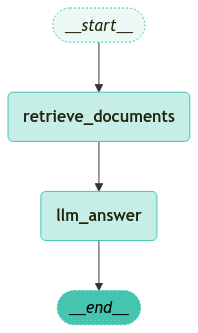

In [10]:
from graphs import visualize_graph

# 그래프 시각화
visualize_graph(app)

### 5. 그래프 실행

In [12]:
from langchain_core.runnables import RunnableConfig
from langchain_print import invoke_graph, stream_graph, random_uuid

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": random_uuid()},
)

inputs = GraphState(question="AI 위험 유형 및 사례 분석에 대해 설명해주세요.")

invoke_graph(app, inputs, config)


🔄 Node: retrieve_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('user', 'AI 위험 유형 및 사례 분석에 대해 설명해주세요.')
('assistant', 'AI 위험 유형은 크게 두 가지로 분류됩니다: \n\n1. **악의적 사용 위험**: 가짜 콘텐츠 생성, 허위 정보 생성, 사용자 설득 및 여론 조작, 사이버 공격 등.\n2. **오작동 위험**: 시스템의 자동적인 불안전 작동 및 의사결정 오류.\n\n이러한 위험들은 기술적 결함을 넘어 사회적, 제도적 요인까지 포함하고 있으며, 명확한 가이드라인과 기준 마련이 필요합니다.\n\n**Source**\n- data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (page 3, 10, 14, 27)')


In [13]:
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AI 위험 유형은 크게 두 가지로 나눌 수 있습니다:

1. **악의적 사용 위험**: 가짜 콘텐츠 생성, 허위 정보 생성, 사용자 설득 및 여론 조작, 사이버 공격 등.
2. **오작동 위험**: 시스템의 자동적인 불안전 작동 및 의사결정 오류.

이러한 위험들은 기술적 결함을 넘어 사회적, 제도적 요인까지 포함하고 있으며, 명확한 가이드라인과 기준 마련이 필요합니다.

**Source**
- data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (page 3, 10, 14, 27)

In [15]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: AI 위험 유형 및 사례 분석에 대해 설명해주세요.
Answer:
AI 위험 유형은 크게 두 가지로 나눌 수 있습니다:

1. **악의적 사용 위험**: 가짜 콘텐츠 생성, 허위 정보 생성, 사용자 설득 및 여론 조작, 사이버 공격 등.
2. **오작동 위험**: 시스템의 자동적인 불안전 작동 및 의사결정 오류.

이러한 위험들은 기술적 결함을 넘어 사회적, 제도적 요인까지 포함하고 있으며, 명확한 가이드라인과 기준 마련이 필요합니다.

**Source**
- data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (page 3, 10, 14, 27)
